# 📊 Stock Price Prediction using Machine Learning
**Objective:** Predict the next day's closing price using various ML models.
- Data Preprocessing
- Feature Engineering
- Model Training & Evaluation


## 📌 1. Importing Libraries & Loading Data

### 📌 2. Data Preprocessing
- Convert Date column to datetime format
- Handle missing values
- Set Date as index

### 📌 3. Feature Engineering
- Moving Averages (MA5, MA10)
- RSI, MACD, Bollinger Bands
- One-hot encoding for categorical variables


### 📌 4. Train-Test Split & Scaling
- Split data into training and testing sets
- Apply StandardScaler to normalize data

### 📌 5. Model Training & Evaluation
- Linear Regression
- XGBoost
- LightGBM
- Decision Tree


### 📌 6. Model Performance Comparison
- Compare models using MAE, RMSE, and R² scores
- Identify the best model based on generalization performance

### 📌 7. Final Visualization
- Scatter plot of real vs predicted values
- Line plot for stock price trends

In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-market-analysis-data/stocks.csv


In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve, \
    RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import RocCurveDisplay
import joblib
from sklearn.impute import KNNImputer
import calendar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)



In [57]:
df = pd.read_csv("/kaggle/input/stock-market-analysis-data/stocks.csv")
df.head()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


Target value:Close

In [58]:
def check_df(dataframe, head=5):
    print(dataframe.shape)
    print(dataframe.dtypes)
    print(dataframe.head(head))
    print(dataframe.tail(head))
    print(dataframe.isnull().sum())
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

(248, 8)
Ticker        object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
  Ticker        Date        Open        High         Low       Close  \
0   AAPL  2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL  2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL  2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL  2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL  2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  
0  154.414230  83322600  
1  151.688400  64120100  
2  150.639999  56007100  
3  151.009995  57450700  
4  153.850006  62199000  
    Ticker        Date        Open        High         Low       Close  \
243   GOOG  2023-05-01  107.720001  108.680000  107.500000  107.709999   
244   GOOG  2023-05-02  107.660004  107.730003  104.500000  105.980003  

In [59]:
df["Ticker"].value_counts()

Ticker
AAPL    62
MSFT    62
NFLX    62
GOOG    62
Name: count, dtype: int64

In [61]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [62]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Weekday"] = df["Date"].dt.weekday
df["is_weekend"] = df["Weekday"].apply(lambda x: 1 if x >= 5 else 0)
df["Day_of_Year"] = df["Date"].dt.dayofyear
df["Quarter"] = df["Date"].dt.quarter
df["Days_in_Month"] = df.apply(lambda row: calendar.monthrange(row["Year"], row["Month"])[1], axis=1)

# Günlük sin ve cos dönüşümleri (ayın uzunluğuna göre ölçekleme)
df["Day_sin"] = np.sin(2 * np.pi * df["Day"] / df["Days_in_Month"])
df["Day_cos"] = np.cos(2 * np.pi * df["Day"] / df["Days_in_Month"])

# Aylık sin ve cos dönüşümleri
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

# Yılın gününe göre sin ve cos dönüşümleri (Seasonality için)
df["Day_of_Year_sin"] = np.sin(2 * np.pi * df["Day_of_Year"] / 365)
df["Day_of_Year_cos"] = np.cos(2 * np.pi * df["Day_of_Year"] / 365)

df = df.drop(columns=["Days_in_Month", "Day", "Month", "Year", "Day_of_Year"])

print(df.head())

  Ticker       Date        Open        High         Low       Close  \
0   AAPL 2023-02-07  150.639999  155.229996  150.639999  154.649994   
1   AAPL 2023-02-08  153.880005  154.580002  151.169998  151.919998   
2   AAPL 2023-02-09  153.779999  154.330002  150.419998  150.869995   
3   AAPL 2023-02-10  149.460007  151.339996  149.220001  151.009995   
4   AAPL 2023-02-13  150.949997  154.259995  150.919998  153.850006   

    Adj Close    Volume  Weekday  is_weekend  Quarter   Day_sin       Day_cos  \
0  154.414230  83322600        1           0        1  1.000000  6.123234e-17   
1  151.688400  64120100        2           0        1  0.974928 -2.225209e-01   
2  150.639999  56007100        3           0        1  0.900969 -4.338837e-01   
3  151.009995  57450700        4           0        1  0.781831 -6.234898e-01   
4  153.850006  62199000        0           0        1  0.222521 -9.749279e-01   

   Month_sin  Month_cos  Day_of_Year_sin  Day_of_Year_cos  
0   0.866025        0.5   

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Ticker           248 non-null    object        
 1   Date             248 non-null    datetime64[ns]
 2   Open             248 non-null    float64       
 3   High             248 non-null    float64       
 4   Low              248 non-null    float64       
 5   Close            248 non-null    float64       
 6   Adj Close        248 non-null    float64       
 7   Volume           248 non-null    int64         
 8   Weekday          248 non-null    int32         
 9   is_weekend       248 non-null    int64         
 10  Quarter          248 non-null    int32         
 11  Day_sin          248 non-null    float64       
 12  Day_cos          248 non-null    float64       
 13  Month_sin        248 non-null    float64       
 14  Month_cos        248 non-null    float64  

In [64]:
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

In [65]:
df.head()

,Ticker,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,Day_sin,Day_cos,Month_sin,Month_cos,Day_of_Year_sin,Day_of_Year_cos
Date,,,,,,,,,,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980


In [66]:
df['Target'] = df.groupby('Ticker')['Adj Close'].shift(-1)  # Bir sonraki günün fiyatını target yap

In [67]:
df.head(20)

,Ticker,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,Day_sin,Day_cos,Month_sin,Month_cos,Day_of_Year_sin,Day_of_Year_cos,Target
Date,,,,,,,,,,,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,151.688400
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,266.063599
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,100.000000
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400,1,0,1,1.000000,6.123234e-17,0.866025,0.5,0.608477,0.793572,366.829987
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,95.459999
2023-02-08,MSFT,273.200012,276.760010,266.209991,266.730011,266.063599,54686000,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,262.961365
2023-02-08,AAPL,153.880005,154.580002,151.169998,151.919998,151.688400,64120100,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,150.639999
2023-02-08,NFLX,360.019989,368.190002,358.309998,366.829987,366.829987,6253200,2,0,1,0.974928,-2.225209e-01,0.866025,0.5,0.622047,0.782980,362.500000
2023-02-09,MSFT,273.799988,273.980011,262.799988,263.619995,262.961365,42375100,3,0,1,0.900969,-4.338837e-01,0.866025,0.5,0.635432,0.772157,262.442657


In [68]:
df.isnull().sum()

Ticker             0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Weekday            0
is_weekend         0
Quarter            0
Day_sin            0
Day_cos            0
Month_sin          0
Month_cos          0
Day_of_Year_sin    0
Day_of_Year_cos    0
Target             4
dtype: int64

In [69]:
df.dropna(subset=["Target"],inplace=True)

In [70]:
df.isnull().sum()

Ticker             0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Weekday            0
is_weekend         0
Quarter            0
Day_sin            0
Day_cos            0
Month_sin          0
Month_cos          0
Day_of_Year_sin    0
Day_of_Year_cos    0
Target             0
dtype: int64

In [71]:
df['Close_Adj_Diff'] = df['Adj Close'] - df['Close']

In [72]:
print(df['Close_Adj_Diff'].describe())

count    244.000000
mean      -0.019287
std        0.106384
min       -0.679993
25%        0.000000
50%        0.000000
75%        0.000000
max        0.000000
Name: Close_Adj_Diff, dtype: float64


In [73]:
print(df.head())
print(df.isnull().sum())

           Ticker        Open        High         Low       Close   Adj Close  \
Date                                                                            
2023-02-07   AAPL  150.639999  155.229996  150.639999  154.649994  154.414230   
2023-02-07   MSFT  260.529999  268.769989  260.079987  267.559998  266.891510   
2023-02-07   GOOG  103.629997  108.669998  103.547997  108.040001  108.040001   
2023-02-07   NFLX  358.510010  364.179993  354.179993  362.950012  362.950012   
2023-02-08   GOOG  102.690002  103.580002   98.455002  100.000000  100.000000   

              Volume  Weekday  is_weekend  Quarter   Day_sin       Day_cos  \
Date                                                                         
2023-02-07  83322600        1           0        1  1.000000  6.123234e-17   
2023-02-07  50841400        1           0        1  1.000000  6.123234e-17   
2023-02-07  33738800        1           0        1  1.000000  6.123234e-17   
2023-02-07   6289400        1           0 

**Feature Engineering**
* Daily-Return(Günlük Değişim Yüzdesi)
* Moving Average - MA(Hareketli Ortalama )
* Volatilite(Fiyat dalgalanmalarının büyüklüğü )
* Relative Strength Index - Göreceli Güç Endeksi(RSI)
* Moving Average Convergence Divergence - Hareketli Ortalama Yakınsama(MACD)

In [74]:
df['Daily_Return'] = df.groupby('Ticker')['Adj Close'].pct_change()

In [75]:
df["MA_5"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(window=5).mean())
df["MA_10"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(window=10).mean())

In [76]:
df["Volatilite"] = df.groupby("Ticker")["Adj Close"].transform(lambda x: x.rolling(window=5).std())

In [78]:
def compute_rsi(series, window=14):
    delta = series.diff()
    
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Kazançları al
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Kayıpları al
    
    rs = gain / loss
    
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: compute_rsi(x, window=14))

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: Ru

In [79]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Ticker,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,...,Month_cos,Day_of_Year_sin,Day_of_Year_cos,Target,Close_Adj_Diff,Daily_Return,MA_5,MA_10,Volatilite,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,1,0,1,...,0.5,0.608477,0.793572,151.688400,-0.235764,NaN,NaN,NaN,NaN,NaN
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400,1,0,1,...,0.5,0.608477,0.793572,266.063599,-0.668488,NaN,NaN,NaN,NaN,NaN
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800,1,0,1,...,0.5,0.608477,0.793572,100.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400,1,0,1,...,0.5,0.608477,0.793572,366.829987,0.000000,NaN,NaN,NaN,NaN,NaN
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000,2,0,1,...,0.5,0.622047,0.782980,95.459999,0.000000,-0.074417,NaN,NaN,NaN,NaN


In [80]:
df.isnull().sum()

Ticker              0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
Weekday             0
is_weekend          0
Quarter             0
Day_sin             0
Day_cos             0
Month_sin           0
Month_cos           0
Day_of_Year_sin     0
Day_of_Year_cos     0
Target              0
Close_Adj_Diff      0
Daily_Return        4
MA_5               16
MA_10              36
Volatilite         16
RSI                52
dtype: int64

In [81]:
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data.ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd, signal_line

df['MACD'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: compute_macd(x)[0])
df['MACD_Signal'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: compute_macd(x)[1])

In [82]:
df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Ticker,Open,High,Low,Close,Adj Close,Volume,Weekday,is_weekend,Quarter,...,Day_of_Year_cos,Target,Close_Adj_Diff,Daily_Return,MA_5,MA_10,Volatilite,RSI,MACD,MACD_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-07,AAPL,150.639999,155.229996,150.639999,154.649994,154.414230,83322600,1,0,1,...,0.793572,151.688400,-0.235764,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2023-02-07,MSFT,260.529999,268.769989,260.079987,267.559998,266.891510,50841400,1,0,1,...,0.793572,266.063599,-0.668488,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2023-02-07,GOOG,103.629997,108.669998,103.547997,108.040001,108.040001,33738800,1,0,1,...,0.793572,100.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2023-02-07,NFLX,358.510010,364.179993,354.179993,362.950012,362.950012,6289400,1,0,1,...,0.793572,366.829987,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2023-02-08,GOOG,102.690002,103.580002,98.455002,100.000000,100.000000,73546000,2,0,1,...,0.782980,95.459999,0.000000,-0.074417,NaN,NaN,NaN,NaN,-0.641368,-0.128274


In [83]:
def compute_bollinger_bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

df['BB_Upper'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: compute_bollinger_bands(x)[0])
df['BB_Lower'] = df.groupby('Ticker')['Adj Close'].transform(lambda x: compute_bollinger_bands(x)[1])

In [84]:
df.isnull().sum()

Ticker              0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
Weekday             0
is_weekend          0
Quarter             0
Day_sin             0
Day_cos             0
Month_sin           0
Month_cos           0
Day_of_Year_sin     0
Day_of_Year_cos     0
Target              0
Close_Adj_Diff      0
Daily_Return        4
MA_5               16
MA_10              36
Volatilite         16
RSI                52
MACD                0
MACD_Signal         0
BB_Upper           76
BB_Lower           76
dtype: int64

In [85]:
knn_imputer = KNNImputer(n_neighbors=5)
numeric_cols = df.select_dtypes(include=[np.number]).columns 
df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

In [86]:
df.isnull().sum()

Ticker             0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Weekday            0
is_weekend         0
Quarter            0
Day_sin            0
Day_cos            0
Month_sin          0
Month_cos          0
Day_of_Year_sin    0
Day_of_Year_cos    0
Target             0
Close_Adj_Diff     0
Daily_Return       0
MA_5               0
MA_10              0
Volatilite         0
RSI                0
MACD               0
MACD_Signal        0
BB_Upper           0
BB_Lower           0
dtype: int64

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2023-02-07 to 2023-05-04
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ticker           244 non-null    object 
 1   Open             244 non-null    float64
 2   High             244 non-null    float64
 3   Low              244 non-null    float64
 4   Close            244 non-null    float64
 5   Adj Close        244 non-null    float64
 6   Volume           244 non-null    float64
 7   Weekday          244 non-null    float64
 8   is_weekend       244 non-null    float64
 9   Quarter          244 non-null    float64
 10  Day_sin          244 non-null    float64
 11  Day_cos          244 non-null    float64
 12  Month_sin        244 non-null    float64
 13  Month_cos        244 non-null    float64
 14  Day_of_Year_sin  244 non-null    float64
 15  Day_of_Year_cos  244 non-null    float64
 16  Target           244 non-null    float64
 1

In [88]:
df = pd.get_dummies(df,columns=["Ticker"],drop_first=True,dtype=int)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2023-02-07 to 2023-05-04
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             244 non-null    float64
 1   High             244 non-null    float64
 2   Low              244 non-null    float64
 3   Close            244 non-null    float64
 4   Adj Close        244 non-null    float64
 5   Volume           244 non-null    float64
 6   Weekday          244 non-null    float64
 7   is_weekend       244 non-null    float64
 8   Quarter          244 non-null    float64
 9   Day_sin          244 non-null    float64
 10  Day_cos          244 non-null    float64
 11  Month_sin        244 non-null    float64
 12  Month_cos        244 non-null    float64
 13  Day_of_Year_sin  244 non-null    float64
 14  Day_of_Year_cos  244 non-null    float64
 15  Target           244 non-null    float64
 16  Close_Adj_Diff   244 non-null    float64
 1

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Korelasyon Matrisi")
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [95]:
correlation_matrix = df.corr().abs()
high_corr_vars = correlation_matrix[correlation_matrix > 0.95]
print(high_corr_vars)

                     Open      High       Low     Close  Adj Close  Volume  \
Open             1.000000  0.999624  0.999646  0.999170   0.999167     NaN   
High             0.999624  1.000000  0.999652  0.999642   0.999638     NaN   
Low              0.999646  0.999652  1.000000  0.999659   0.999657     NaN   
Close            0.999170  0.999642  0.999659  1.000000   0.999999     NaN   
Adj Close        0.999167  0.999638  0.999657  0.999999   1.000000     NaN   
Volume                NaN       NaN       NaN       NaN        NaN     1.0   
Weekday               NaN       NaN       NaN       NaN        NaN     NaN   
is_weekend            NaN       NaN       NaN       NaN        NaN     NaN   
Quarter               NaN       NaN       NaN       NaN        NaN     NaN   
Day_sin               NaN       NaN       NaN       NaN        NaN     NaN   
Day_cos               NaN       NaN       NaN       NaN        NaN     NaN   
Month_sin             NaN       NaN       NaN       NaN        N

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


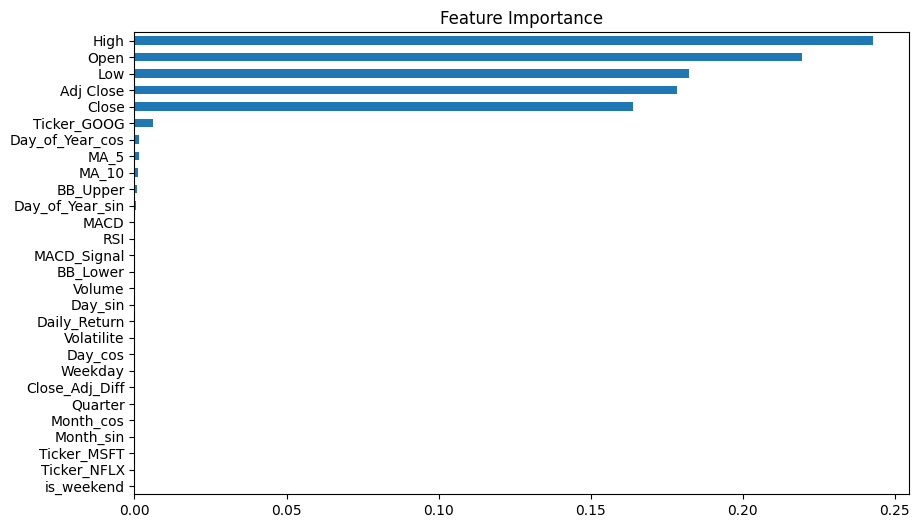

In [96]:
X = df.drop(columns=['Target'])  # Hedef değişkeni çıkarıyoruz
y = df['Target']

# Random Forest Modeli Eğitme
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature Importance Çizimi
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10,6), title="Feature Importance")
plt.show()


In [97]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [98]:
scaler = StandardScaler()

In [99]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [115]:
X_train = pd.DataFrame(X_train_scaled,columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled,columns=X.columns, index=X_test.index)

In [122]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Verilen modeli eğitir, test seti üzerinde tahmin yapar ve performans metriklerini döndürür.
    
    Parametreler:
    model : Makine öğrenmesi modeli (örneğin: LinearRegression(), XGBRegressor())
    X_train, X_test : Eğitim ve test özellikleri
    y_train, y_test : Eğitim ve test hedef değişkenleri
    model_name : Modelin ismi (String olarak)
    
    Çıktı:
    Modelin MAE, RMSE ve R² skorlarını yazdırır.
    """

    model.fit(X_train, y_train)  # Modeli eğit
    y_pred = model.predict(X_test)  # Modelin tahminini değişkene ata

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE için squared=False olmalı
    r2 = r2_score(y_test, y_pred)

    print(f"📌 Model Name: {model_name}" )
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    print("--------")



In [125]:
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

for model_name, model in models.items():
    evaluate_model(model, X_train, X_test, y_train, y_test, model_name)

📌 Model Name: Linear Regression
MAE: 3.2788290568448537
RMSE: 4.812013862884145
R2: 0.9971831135373146
--------
📌 Model Name: XGBoost
MAE: 6.057924076002472
RMSE: 13.997438314659945
R2: 0.9761651332903712
--------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 195, number of used features: 26
[LightGBM] [Info] Start training from score 219.273837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [126]:
def check_overfitting(model, X_train, X_test, y_train, y_test, model_name):
    """
    Modelin eğitim ve test hatalarını karşılaştırarak overfit olup olmadığını kontrol eder.
    """
    y_train_pred = model.predict(X_train)
    
    y_test_pred = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print(f"📌 {model_name} - Overfitting Kontrolü:")
    print(f"📌 Eğitim Seti -> MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")
    print(f"📌 Test Seti   -> MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}\n")

In [127]:
for model_name, model in models.items():
    check_overfitting(model, X_train, X_test, y_train, y_test, model_name)

📌 Linear Regression - Overfitting Kontrolü:
📌 Eğitim Seti -> MAE: 2.8821239499472946, RMSE: 4.170497325727676, R²: 0.9978902512470369
📌 Test Seti   -> MAE: 3.2788290568448537, RMSE: 4.812013862884145, R²: 0.9971831135373146

📌 XGBoost - Overfitting Kontrolü:
📌 Eğitim Seti -> MAE: 0.001420906262519449, RMSE: 0.001965782146181642, R²: 0.9999999995312667
📌 Test Seti   -> MAE: 6.057924076002472, RMSE: 13.997438314659945, R²: 0.9761651332903712

📌 LightGBM - Overfitting Kontrolü:
📌 Eğitim Seti -> MAE: 1.4094639175809698, RMSE: 2.316792034468497, R²: 0.9993489278066703
📌 Test Seti   -> MAE: 3.9260480368126998, RMSE: 5.709122953687538, R²: 0.9960348977104848

📌 Decision Tree - Overfitting Kontrolü:
📌 Eğitim Seti -> MAE: 0.0, RMSE: 0.0, R²: 1.0
📌 Test Seti   -> MAE: 3.9380622396663743, RMSE: 5.996618254404984, R²: 0.9956255001299197



Best Model:Linear Regression

In [128]:
final_model = LinearRegression()
final_model.fit(X_train, y_train)

LinearRegression()

In [130]:
# Modelin katsayılarını alalım
coef_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": final_model.coef_})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)


In [140]:
y_pred_final = final_model.predict(X_test)

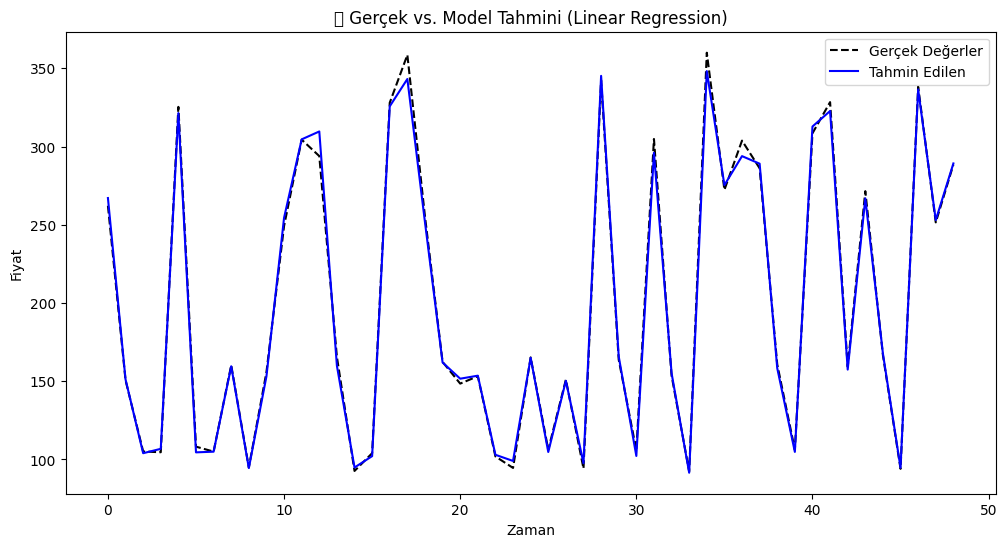

In [137]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Gerçek Değerler", color='black', linestyle='dashed')
plt.plot(y_pred_final, label="Tahmin Edilen", color='blue')
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.title("📌 Gerçek vs. Model Tahmini (Linear Regression)")
plt.legend()
plt.show()

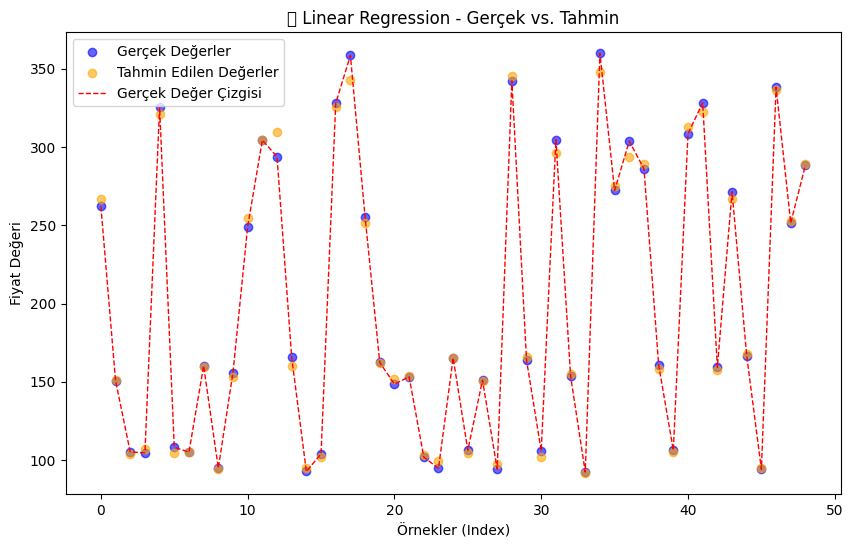

In [144]:
plt.figure(figsize=(10, 6))

# Gerçek değerleri gösteren scatter plot
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label="Gerçek Değerler")

# Modelin tahmin ettiği değerleri gösteren scatter plot
plt.scatter(range(len(y_test)), y_pred_final, color='orange', alpha=0.6, label="Tahmin Edilen Değerler")

# Kırmızı çizgi: tahmin çizgisi
plt.plot(range(len(y_test)), y_test, color='red', linestyle='--', linewidth=1, label="Gerçek Değer Çizgisi")

plt.xlabel("Örnekler (Index)")
plt.ylabel("Fiyat Değeri")
plt.title("📌 Linear Regression - Gerçek vs. Tahmin")
plt.legend()
plt.show()

In [145]:
prediction_errors = pd.DataFrame({"Gerçek Değer": y_test, "Tahmin": y_pred_final})
prediction_errors["Hata"] = abs(prediction_errors["Gerçek Değer"] - prediction_errors["Tahmin"])

print("📌 En Büyük 10 Tahmin Hatası:")
print(prediction_errors.sort_values(by="Hata", ascending=False).head(10))

📌 En Büyük 10 Tahmin Hatası:
            Gerçek Değer      Tahmin       Hata
Date                                           
2023-03-21    293.899994  309.632654  15.732660
2023-02-10    358.570007  343.166751  15.403256
2023-02-13    359.959991  348.212682  11.747310
2023-03-14    303.790009  293.872634   9.917374
2023-04-26    304.829987  296.002943   8.827044
2023-03-23    328.390015  322.707953   5.682062
2023-04-12    165.559998  159.909380   5.650617
2023-02-23    249.220001  254.438349   5.218348
2023-02-15    262.149994  267.089062   4.939068
2023-02-13    271.490021  266.869198   4.620822
